<a href="https://colab.research.google.com/github/sandeep-kumar-barada/Defect-Detection-on-Manufacturing-Images/blob/main/Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install -r requirements.txt # install the expected libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install torchmetrics

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
#import torchmetrics
import torchvision
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
# add path variable
data_dtestdef = "/content/drive/MyDrive/Vision/Visual/casting_data/test/def_front/"
data_dtestok = "/content/drive/MyDrive/Vision/Visual/casting_data/test/ok_front/"
data_dtraindef = "/content/drive/MyDrive/Vision/Visual/casting_data/train/def_front/"
data_dtrainok = "/content/drive/MyDrive/Vision/Visual/casting_data/train/ok_front/"
var = [data_dtraindef,data_dtrainok,data_dtestdef,data_dtestok]

In [ ]:
# import dataset from the local machine
data_traindef,data_trainok,data_testdef,data_testok = [],[],[],[]
data_var = [data_traindef,data_trainok,data_testdef,data_testok]
i = 0
for _ in var:
    for image in os.listdir(_):
        image_path = os.path.join(_, image)
        with Image.open(image_path) as img:
            data_var[i].append(img.copy())
    i+=1

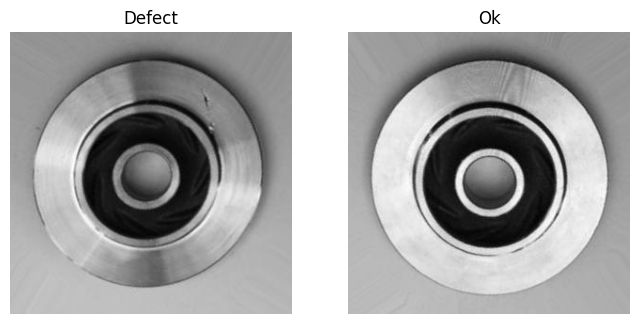

In [ ]:
num_images = len(data_var[:2])
fig, axs = plt.subplots(1,num_images, figsize=(8, 8*num_images))
if num_images == 1:
    axs = [axs]
nam = ["Defect","Ok"]
i = 0
for ax, images in zip(axs, data_var[:2]):
    ax.imshow(images[0])
    ax.axis('off')
    ax.set_title(nam[i])
    i+=1
plt.show()

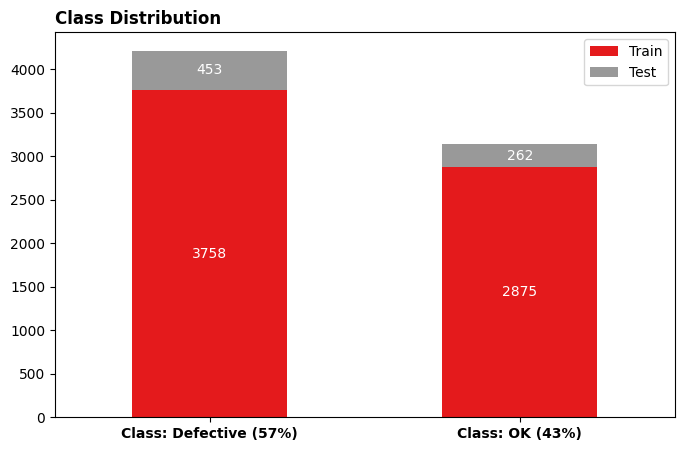

In [ ]:
dist_df = pd.DataFrame(
    data = [[len(data_var[0]),len(data_var[1])],[len(data_var[2]),len(data_var[3])]],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Set1')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25,
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [ ]:
train_d = data_var[0] + data_var[1]
test_d = data_var[2] + data_var[3]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torch.utils.data import Dataset

class CastingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Convert to RGB to ensure 3 channels
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_image_paths = [os.path.join(data_dtraindef, img) for img in os.listdir(data_dtraindef)] + \
                    [os.path.join(data_dtrainok, img) for img in os.listdir(data_dtrainok)]

test_image_paths = [os.path.join(data_dtestdef, img) for img in os.listdir(data_dtestdef)] + \
                   [os.path.join(data_dtestok, img) for img in os.listdir(data_dtestok)]

train_labels = [1] * len(os.listdir(data_dtraindef)) + [0] * len(os.listdir(data_dtrainok))
test_labels = [1] * len(os.listdir(data_dtestdef)) + [0] * len(os.listdir(data_dtestok))

In [ ]:
from torchvision.transforms import ToTensor

transform = ToTensor()

train_dataset = CastingDataset(train_image_paths, train_labels, transform=transform)
test_dataset = CastingDataset(test_image_paths, test_labels, transform=transform)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Number of batches in train dataloader:", len(train_dataloader))
print("Number of batches in test dataloader:", len(test_dataloader))

images, labels = next(iter(train_dataloader))
print("Shape of image batch:", images.shape)
print("Shape of label batch:", labels.shape)

Train dataset size: 6633
Test dataset size: 715
Number of batches in train dataloader: 52
Number of batches in test dataloader: 6
Shape of image batch: torch.Size([128, 3, 300, 300])
Shape of label batch: torch.Size([128])


In [ ]:
class CastingD_detect_CNN(nn.Module):
  def __init__(self):
    super(CastingD_detect_CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
    self.fc1 = nn.Linear(in_features=32*75*75, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=1)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 32*75*75) # Flatten the tensor
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
Model = CastingD_detect_CNN().to(device)
optimizer = optim.Adam(Model.parameters(), lr = 0.001)
criterian = nn.BCEWithLogitsLoss()

In [ ]:
n_epoch = 100
for epoch in range(n_epoch):
  Model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_dataloader):
    images, labels = images.to(device), labels.to(device)
    labels = labels.float().unsqueeze(1)
    optimizer.zero_grad()
    outputs = Model(images)
    loss = criterian(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('Epoch:[{}/{}], loss:{:.4f}'.format(epoch+1,n_epoch,running_loss/len(train_dataloader)))

100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[1/100], loss:0.7757


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[2/100], loss:0.3318


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[3/100], loss:0.2026


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[4/100], loss:0.1645


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[5/100], loss:0.0884


100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


Epoch:[6/100], loss:0.0523


100%|██████████| 52/52 [00:42<00:00,  1.23it/s]


Epoch:[7/100], loss:0.0264


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[8/100], loss:0.0228


100%|██████████| 52/52 [00:41<00:00,  1.24it/s]


Epoch:[9/100], loss:0.0175


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[10/100], loss:0.0177


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[11/100], loss:0.0164


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[12/100], loss:0.0096


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[13/100], loss:0.0094


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[14/100], loss:0.0125


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[15/100], loss:0.0107


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[16/100], loss:0.0082


100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


Epoch:[17/100], loss:0.0055


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[18/100], loss:0.0057


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[19/100], loss:0.0041


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[20/100], loss:0.0051


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[21/100], loss:0.0038


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[22/100], loss:0.0043


100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


Epoch:[23/100], loss:0.0045


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[24/100], loss:0.0032


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[25/100], loss:0.0045


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[26/100], loss:0.0185


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[27/100], loss:0.0310


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[28/100], loss:0.0066


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[29/100], loss:0.0030


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[30/100], loss:0.0029


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[31/100], loss:0.0023


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[32/100], loss:0.0021


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[33/100], loss:0.0019


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[34/100], loss:0.0015


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[35/100], loss:0.0016


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[36/100], loss:0.0028


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[37/100], loss:0.0051


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[38/100], loss:0.0024


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[39/100], loss:0.6866


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[40/100], loss:0.0582


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[41/100], loss:0.0209


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[42/100], loss:0.0150


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[43/100], loss:0.0116


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[44/100], loss:0.0101


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[45/100], loss:0.0095


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[46/100], loss:0.0080


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[47/100], loss:0.0052


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[48/100], loss:0.0045


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[49/100], loss:0.0038


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[50/100], loss:0.0040


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[51/100], loss:0.0032


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[52/100], loss:0.0029


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[53/100], loss:0.0030


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[54/100], loss:0.0027


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[55/100], loss:0.0030


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[56/100], loss:0.0033


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[57/100], loss:0.0025


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[58/100], loss:0.0022


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[59/100], loss:0.0022


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[60/100], loss:0.0019


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[61/100], loss:0.0019


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[62/100], loss:0.0021


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[63/100], loss:0.0016


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[64/100], loss:0.0016


100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


Epoch:[65/100], loss:0.0014


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[66/100], loss:0.0018


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[67/100], loss:0.0014


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[68/100], loss:0.0013


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[69/100], loss:0.0014


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[70/100], loss:0.0010


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[71/100], loss:0.0013


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[72/100], loss:0.0012


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[73/100], loss:0.0008


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[74/100], loss:0.0015


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[75/100], loss:0.0009


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[76/100], loss:0.0006


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[77/100], loss:0.0008


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[78/100], loss:0.0008


100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


Epoch:[79/100], loss:0.0009


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[80/100], loss:0.0008


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[81/100], loss:0.0005


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[82/100], loss:0.0006


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[83/100], loss:0.0011


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[84/100], loss:0.0008


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[85/100], loss:0.0013


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[86/100], loss:0.0009


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[87/100], loss:0.0011


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[88/100], loss:0.0005


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[89/100], loss:0.0003


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[90/100], loss:0.0004


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[91/100], loss:0.0004


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[92/100], loss:0.0004


100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


Epoch:[93/100], loss:0.0003


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[94/100], loss:0.0003


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch:[95/100], loss:0.0004


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch:[96/100], loss:0.0005


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[97/100], loss:0.0003


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch:[98/100], loss:0.0002


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch:[99/100], loss:0.0003


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]

Epoch:[100/100], loss:0.0002


In [ ]:
Model.eval()
correct_predictions = 0
total_samples = 0


accuracy = torchmetrics.Accuracy(task="binary", num_classes=2).to(device)
f1_score_metric = torchmetrics.F1Score(task="binary", num_classes=2).to(device)

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = Model(images)

        predicted = torch.round(torch.sigmoid(outputs))
        predicted = predicted.squeeze(1).long()
        labels = labels.long()
        accuracy.update(predicted, labels)
        f1_score_metric.update(predicted, labels)


final_accuracy = accuracy.compute()
final_f1_score = f1_score_metric.compute()


print('Accuracy of the model on the test images: {:.2f}%'.format(final_accuracy * 100))
print('F1 Score of the model on the test images: {:.4f}'.format(final_f1_score))

Accuracy of the model on the test images: 99.58%
F1 Score of the model on the test images: 0.9967


In [ ]:
torch.save(Model.state_dict(),'Casting_defect_detect.pth')

In [ ]:
y_true = []
y_pred = []
Model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = Model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        predicted = predicted.squeeze(1).cpu().numpy()
        labels = labels.cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(predicted)

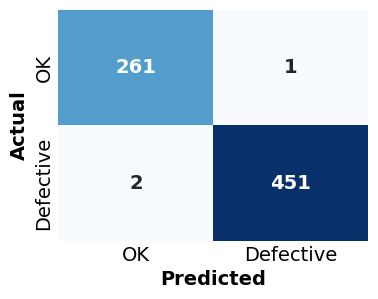

In [ ]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [ ]:
Model = torch.load('/Casting_defect_detect.pth')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.